# Lab 08 - Distances and PCA

Name: Jake Schaeffer  
Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2020  
Instructor: Brian King

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.decomposition import PCA

### 1) [P] Set up a pandas data frame with the following 8 observations and 3 variables:

In [3]:
df = pd.DataFrame(data= {"test1":["A","C","C","B","A","B","C","B"],
 "test2":["excellent","fair","good","fair","poor","excellent","good","good"],
 "test3":[25,32,60,53,23,37,45,49]},
 index = ["A{}".format(i) for i in range(8)])

df["test1"] = pd.Categorical(df.test1)
df["test2"] = pd.Categorical(df.test2, categories = ["poor","fair","good","excellent"],ordered = True)
print(df)
df.info()

   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32
A2     C       good     60
A3     B       fair     53
A4     A       poor     23
A5     B  excellent     37
A6     C       good     45
A7     B       good     49
<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
test1    8 non-null category
test2    8 non-null category
test3    8 non-null int64
dtypes: category(2), int64(1)
memory usage: 440.0+ bytes


### 2) [P] Show the output of df.describe(include='all'). What does the include='all' parameter do?

In [4]:
#include all makes it so we cinclude the categorical variables
df.describe(include = "all")

,test1,test2,test3
count,8,8,8.000000
unique,3,4,NaN
top,C,good,NaN
freq,3,3,NaN
mean,NaN,NaN,40.500000
std,NaN,NaN,13.416408
min,NaN,NaN,23.000000
25%,NaN,NaN,30.250000
50%,NaN,NaN,41.000000
75%,NaN,NaN,50.000000


### 3) [P] Show the output of df.test1.cat.categories, and df.test2.cat.categories. What is this showing? Does it work for df.test3.cat.categories? (If not, then comment this line out.)

In [5]:
print(df.test1.cat.categories)
print(df.test2.cat.categories)
#df.test3.cat.categories

Index(['A', 'B', 'C'], dtype='object')
Index(['poor', 'fair', 'good', 'excellent'], dtype='object')


### 4) [P] Show the output of df.test1.cat.codes, and df.test2.cat.codes. What is this showing?

In [6]:
print(df.test1.cat.codes)
print(df.test2.cat.codes)
#this shows the categories by their numeric value. A C C B is 0 2 2 1
# excellent fair good is 3 1 2

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8
A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8


### 5) [P] Report the counts of each level of the categorical variables.

In [7]:
print("test1 counts:\n",df.test1.value_counts())
print("\ntest2 counts:\n",df.test2.value_counts())

test1 counts:
 C    3
B    3
A    2
Name: test1, dtype: int64

test2 counts:
 good         3
excellent    2
fair         2
poor         1
Name: test2, dtype: int64


### 6) [P] Report a cross tabulation (i.e. contingency table) between test1 and test2. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas crosstab() function)

In [8]:
pd.crosstab(df.test1,df.test2, margins = True)

test2,poor,fair,good,excellent,All
test1,,,,,
A,1,0,0,1,2
B,0,1,1,1,3
C,0,1,2,0,3
All,1,2,3,2,8


### 7) [P] From the previous table, store the contingency table without the margins in a variable called observed

In [9]:
observed  = pd.crosstab(df.test1,df.test2)

### 8) [P] Run a chi-squared test to determine whether test1 and test2 are dependent. Use the contingency table from the previous step. Clearly report the chi2 statistic, the p value, and the degrees of freedom, and then use the p-value to clearly state whether test1 and test2 are independent (assume p=0.05 threshold to test for independence)

In [10]:
chi2 = stats.chi2_contingency(observed)
print("chi2 = {}\np value = {}\nDegrees of Freedom = {}\n".format(chi2[0],chi2[1],chi2[2]))
#p value and DoF chi2[1] chi2[2]
print("Since the p value is above .05, the test is not significant, so we can't conclude that these variables are independent")

chi2 = 6.444444444444444
p value = 0.37528525266160834
Degrees of Freedom = 6

Since the p value is above .05, the test is not significant, so we can't conclude that these variables are independent


### 9) [P] Create a new data frame called df_num, that represents a numeric version of the above. Do NOT do any rescaling of your variables yet!
NOTE: If you do this from a dataframe that has the categorical variables set up properly, then this step is
simple to do. The two choices I generally follow are either: 1) use the cat member of your categorical data,
which stores a CategoricalAccessor object (look it up), or use one of the encoders in the
sklearn.preprocessing module. The first option is easier, and yet another reason why it's so important
to take the time to preprocess your data as correctly and error-free as possible.
Your resulting data frame at the end of this step should be as follows:

In [11]:
df_num = pd.DataFrame({"test1":df.test1.cat.codes,"test2":df.test2.cat.codes,"test3":df.test3})
df_num

,test1,test2,test3
A0,0,3,25
A1,2,1,32
A2,2,2,60
A3,1,1,53
A4,0,0,23
A5,1,3,37
A6,2,2,45
A7,1,2,49


### 10) [P] As you learned in lecture, you absolutely must rescale your data to fall on a similar scale. There are different approaches to doing so. A standardized zscore is among the most common, but not necessarily always the best approach, especially when you are dealing with numeric representations of true categorical data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have categorical data. Let's first try to rescale our data to all fall between the values of 0 and 1. Use the MinMaxScaler in sklearn.preprocessing to rescale all variables to fall between 0 and 1. Store the transformed data as a pandas data frame called df_num_zeroone,. Your result should look as follows:

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_num_zeroone = pd.DataFrame(scaler.fit_transform(df_num),index = df.index,columns = df.columns)
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.054054
A1,1.0,0.333333,0.243243
A2,1.0,0.666667,1.000000
A3,0.5,0.333333,0.810811
A4,0.0,0.000000,0.000000
A5,0.5,1.000000,0.378378
A6,1.0,0.666667,0.594595
A7,0.5,0.666667,0.702703


### 11) [P] Notice the value of test3. Quite often, when we have solid knowledge of what we expect our range to be, then we can rescale our data using that knowledge. In the case of test3, you learned that the data must fall between 0 and 100. Therefore, reassign test3 so that the min and max before rescaling are assuming to be between 0 and 100, respectively. (i.e. simply divide the original variable by 100)

In [13]:
df_num_zeroone.test3 = df_num.test3.apply(lambda x: x/100)

### 12) [P] Compute a single distance matrix called distmat_zeroone. Use a standard Euclidean distance measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. 
(HINT –
study the output of the distance matrix functions! They do not output a square matrix. Look at the
squareform function. The pdist and squareform functions are in scipy.spatial.distance).

In [14]:
from scipy.spatial.distance import pdist, squareform
distmat_zeroone = pd.DataFrame(data = squareform(pdist(df_num)),index = df_num.index,columns = df_num.index)
distmat_zeroone

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000000,7.549834,35.071356,28.089144,3.605551,12.041595,20.124612,24.041631
A1,7.549834,0.000000,28.017851,21.023796,9.273618,5.477226,13.038405,17.058722
A2,35.071356,28.017851,0.000000,7.141428,37.107951,23.043437,15.000000,11.045361
A3,28.089144,21.023796,7.141428,0.000000,30.033315,16.124515,8.124038,4.123106
A4,3.605551,9.273618,37.107951,30.033315,0.000000,14.352700,22.181073,26.095977
A5,12.041595,5.477226,23.043437,16.124515,14.352700,0.000000,8.124038,12.041595
A6,20.124612,13.038405,15.000000,8.124038,22.181073,8.124038,0.000000,4.123106
A7,24.041631,17.058722,11.045361,4.123106,26.095977,12.041595,4.123106,0.000000


### 13) [P] Output the top three closest pairs of observations. You MUST write Python code to report these results! 
Do
not simply print out your distance matrix and tell me your answers! Consider that this may have been
thousands of observations! Always generate reported answers in code!
For each pair, output the pair of observations from the original dataframe, and the distance between them.
For example, your first closest pair output might have output that looks as follows:

In [15]:
distmat_zeroone[distmat_zeroone != 0].stack().sort_values().head(6)[::2]

A0  A4    3.605551
A3  A7    4.123106
A6  A7    4.123106
dtype: float64

### 14) [P] Now, output the three most distant (least similar) pairs of observations. Again, for each pair, output the two observations, and the distance between them

In [16]:
distmat_zeroone[distmat_zeroone != 0].stack().sort_values().tail(6)[::2]

A4  A3    30.033315
A2  A0    35.071356
    A4    37.107951
dtype: float64

### 15) [P] Create a new data frame, df_num_binarized, that stores the a binarized version for test1 and test2.

In [17]:
df_binarized = pd.get_dummies(df)
df_binarized.test3 = df_binarized.test3.apply(lambda x: x/100)

### 16) [P] Now, compute distmat_binarized by computing the distance matrix for the df_binarized.

In [18]:
distmat_binarized = pd.DataFrame(data = squareform(pdist(df_binarized)),index = df_binarized.index,columns = df_binarized.index)


### 17) [P] Report the three closest pairs, and the three most distant pairs from distmat_binarized

In [19]:
print("distant:\n")
print(distmat_binarized[distmat_binarized != 0].stack().sort_values().tail(6)[::2])
print("\nclose:\n")
print(distmat_binarized[distmat_binarized != 0].stack().sort_values().head(6)[::2])

distant:

A4  A3    2.022375
A0  A2    2.030394
A2  A4    2.033937
dtype: float64

close:

A6  A2    0.150000
A0  A4    1.414355
A3  A7    1.414779
dtype: float64


### 18) [M] Take a moment and compare and contrast your results.
Which method do you think have the better
results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes
between both of the above approaches to transforming your data to numeric results? Why? Summarize what
would have been the best transformation to make for all three variables that would have given the most
accurate results.
OK – Take a breather. That was cool. Consider how valuable that is going to be when the time comes to
assess similarity between observations for, say, clustering hundreds of thousands of observations. These
considerations are precisely the same types of considerations you need to make whether you are
searching for similar observations on

For this next exercise, you are going to use the dataset built into the seaborn library, called 'car_crashes'.
This time, the aim will be determine states that are outliers, but also to apply a PCA to a bit of visualization to help
you confirm states that are outliers.

I think test1 was the most impactful. Since it had the least amount of possible values, the values always had a fairly large distance between them. Only options were 0, .5, or 1. I think that the weight of each variable must be considered in any sort of transformation and also consideration of what the distance really means.

### 19) [P] Load in your next dataset using the following:
df_car_crashes = sns.load_dataset('car_crashes')
The dataset is directly downloaded from:
https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv
Figure out what this dataset is all about. Sometimes, it's easy to figure out. Just Google! And, sometimes we
find interesting publicly available data but we need to make the best guess regarding our variables. For now,
don't worry too much about specifics. This is a very simplified, highly aggregated dataset from much more
extensive statistics drawn from the Insurance Institute for Highway Safety -
https://www.iihs.org/iihs/topics/t/general-statistics/fatalityfacts/state-by-state-overview (NOTE - this might
make a great repository for some project?)

In [20]:
df_car_crashes = sns.load_dataset('car_crashes')

### 20) [P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe, and then drop that column from your dataframe. Show the first five rows.

In [21]:
df_car_crashes.set_index("abbrev",inplace = True)
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


### 21) [P] Create a new dataframe called df_car_crashes_zscore that represents the zscore transformation for df_car_crashes. Again, show the first five rows.

In [22]:
df_car_crashes_zscore = df_car_crashes.apply(zscore)
df_car_crashes_zscore.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,0.737446,1.168148,0.439938,1.002301,0.277692,-0.580083,0.430514
AK,0.565936,1.212695,-0.211311,0.608532,0.807258,0.943258,-0.022900
AZ,0.688443,0.756709,0.187615,0.459357,1.033141,0.070876,-0.981778
AR,1.619498,-0.483614,0.547408,1.676052,1.951700,-0.337701,0.321125
CA,-0.928653,-0.399524,-0.891763,-0.594276,-0.891968,-0.048418,1.266178


### 22) [P] Create a distance matrix called distmat_cars based on the df_car_crashes_zscore. Display the entire distance matrix.

In [23]:
distmat_cars = pd.DataFrame(data = squareform(pdist(df_car_crashes_zscore)),index = df_car_crashes_zscore.index,columns = df_car_crashes_zscore.index)
distmat_cars

abbrev,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
abbrev,,,,,,,,,,,,,,,,,,,,,
AL,0.000000,1.848559,1.875942,2.616265,3.450372,2.687193,4.022977,2.426745,6.627070,2.863217,...,2.272782,1.760396,1.768022,4.073530,2.984473,3.691474,4.099448,2.658679,3.882304,1.345666
AK,1.848559,0.000000,1.461454,2.961700,3.503615,2.674699,3.719860,1.305465,5.923340,2.014017,...,3.030764,2.612893,1.983290,3.820444,3.230915,3.939532,3.874399,2.759540,4.080096,1.794331
AZ,1.875942,1.461454,0.000000,2.592934,3.873068,2.690949,4.341409,2.322674,6.312294,2.471886,...,1.805917,2.413952,2.496229,3.638752,2.564600,3.910659,3.716797,3.094545,3.452450,1.165002
AR,2.616265,2.961700,2.592934,0.000000,4.773783,4.082043,5.511677,3.375632,7.648001,2.722795,...,2.756086,2.090210,2.858256,5.375719,4.012612,4.577666,5.500790,2.401244,5.215076,3.105415
CA,3.450372,3.503615,3.873068,4.773783,0.000000,1.382473,1.360401,2.801377,3.725440,3.294284,...,4.729624,2.984643,4.199246,2.525129,2.637784,1.211871,2.322342,5.589191,3.094339,3.392714
CO,2.687193,2.674699,2.690949,4.082043,1.382473,0.000000,2.171261,2.348937,4.294426,2.884757,...,3.599348,2.449727,3.623915,1.893114,1.579660,1.580230,1.824522,4.943274,2.114426,2.217199
CT,4.022977,3.719860,4.341409,5.511677,1.360401,2.171261,0.000000,2.792618,3.100788,3.490418,...,5.401468,3.816674,4.346224,3.070455,3.461110,2.371614,2.500124,5.938001,3.628320,3.899592
DE,2.426745,1.305465,2.322674,3.375632,2.801377,2.348937,2.792618,0.000000,5.106619,1.442845,...,3.827587,2.556844,2.171300,3.771261,3.324290,3.389056,3.571201,3.438088,4.037819,2.427114
DC,6.627070,5.923340,6.312294,7.648001,3.725440,4.294426,3.100788,5.106619,0.000000,5.343223,...,7.356393,6.230942,7.019399,3.805078,4.898792,3.999740,3.303523,8.418524,4.939871,6.196665


### 23) [P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or column, then sort the output in order. Why would this work? Because an observation that is an outlier should have a relatively high mean distance to all other observations! Do this, and output the entire ordered list in descending order. (HINT: DC should be your largest outlier.)

In [24]:
distmat_cars.mean().sort_values(ascending = False)

abbrev
DC    5.265664
ND    5.257310
SC    5.214264
LA    4.767480
MT    4.759816
WV    4.512766
NJ    4.310802
MA    4.197513
MS    4.048305
AR    3.897635
MD    3.749939
MN    3.719807
OK    3.618059
HI    3.591755
SD    3.585247
TX    3.572109
NY    3.531806
CT    3.514075
WI    3.468777
ID    3.440899
PA    3.440610
UT    3.438146
RI    3.434056
WA    3.296993
FL    3.205449
VA    3.156358
OR    3.130498
CA    3.116879
ME    3.105251
NH    3.100905
IA    3.098437
AK    3.091304
MI    3.072811
NE    3.065206
AL    3.033363
DE    3.021971
AZ    2.999864
TN    2.965254
KY    2.964333
NM    2.914953
IN    2.841386
WY    2.839487
VT    2.820077
NC    2.777656
OH    2.746863
MO    2.734449
GA    2.726648
NV    2.627495
CO    2.617432
IL    2.602264
KS    2.573618
dtype: float64

### 24) [M] From this analysis, which 4 states seem to be strongest outliers?

North Dakota, South Carolina, Louisiana, Montana

### 25) [P] OK. Let's explore the data visually.
First, using the original, unscaled data frame df_car_crashes,
create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of
the point. Create a label near to every point representing the two letter state code.

You should be able to see that LA certainly stands out as an outlier, at least with respect to insurance
premiums vs. losses.

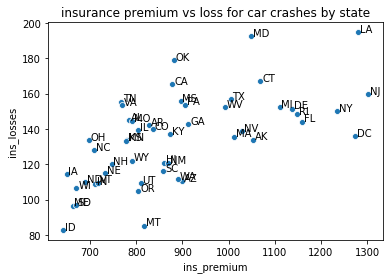

In [25]:
plot = sns.scatterplot(data = df_car_crashes,x = "ins_premium",y="ins_losses")
for line in range(len(df_car_crashes.index)):
    plot.text(df_car_crashes.ins_premium[line]+4,df_car_crashes.ins_losses[line],df_car_crashes.index[line])
plot.set_title("insurance premium vs loss for car crashes by state")
plt.show()    

### 26) [P] Next, generate two interesting plots that show some relationships between variables in the data. 
Try to
use as many variables as you can without creating chaos! Don't just throw in multiple variables for the sake of
showing them, only include them if it makes sense to do so. Your aim is to derive meaning from your data.
Good visualizations tell a story. Strive to use at least one additional variable as size, color, or shape in your
data, so you can show more than just 2 variables on a single plot. Add titles, legends and label your axes as
appropriate.
After each plot, create a markdown cell and briefly draw conclusions from your plot.
Now, we're going to look at the data visually, but use a PCA transformation to help give a better sense of trends
and differences among our data.

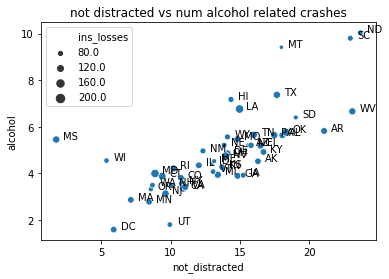

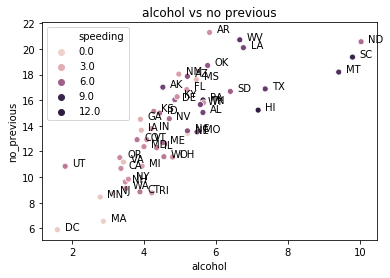

In [26]:
plot2 = sns.scatterplot(data = df_car_crashes,x = "not_distracted",y="alcohol",size = "ins_losses")
for line in range(len(df_car_crashes.index)):
    plot2.text(df_car_crashes.not_distracted[line]+.5,df_car_crashes.alcohol[line],df_car_crashes.index[line])
plot2.set_title("not distracted vs num alcohol related crashes")
plt.show() 

plot3 = sns.scatterplot(data = df_car_crashes,x = "alcohol",y="no_previous",hue = "speeding")
for line in range(len(df_car_crashes.index)):
    plot3.text(df_car_crashes.alcohol[line]+.2,df_car_crashes.no_previous[line],df_car_crashes.index[line])
plot3.set_title("alcohol vs no previous")
plt.show() 

### 27) [P] Run a full PCA on the z_score transformed data. Set n_components to be the same number of columns as the data. Be sure to fit the data to your PCA model, and then output the components, explained variance, and the explained variance ratio.

In [27]:
pca = PCA(n_components = len(df_car_crashes.columns))
pca.fit(df_car_crashes_zscore)
print("\nComponents:\n",pca.components_)
print("\nExplained variance:\n",pca.explained_variance_)
print("\nExplained variance ratio:\n",pca.explained_variance_ratio_)


Components:
 [[ 0.47947078  0.37534719  0.45437635  0.4380328   0.45703414 -0.1308319
  -0.06996048]
 [ 0.06893769  0.0765846   0.03345835  0.04237473  0.0961294   0.6852266
   0.71252436]
 [-0.26908802  0.81826935  0.08293253 -0.12616845 -0.31798812  0.25614247
  -0.26173503]
 [ 0.0389558  -0.36374887  0.14834351  0.1712655   0.03948141  0.65639617
  -0.61839859]
 [ 0.14597659 -0.02282818  0.35479821 -0.85646854  0.33611019  0.04214531
  -0.06327152]
 [-0.16970508 -0.22479246  0.7837677   0.08510479 -0.50401185 -0.11577348
   0.17805184]
 [ 0.80082487  0.01784783 -0.15285774 -0.14247844 -0.55875371  0.04126619
  -0.02804966]]

Explained variance:
 [4.0942308  1.6095732  0.56161403 0.35753958 0.2863854  0.20263316
 0.02802383]

Explained variance ratio:
 [0.57342168 0.22543042 0.07865743 0.05007557 0.04011    0.02837999
 0.00392491]


### 28) [M] Use your intuition – what do the weights of the first couple of components suggest explains most of the variance in the data?

total explains most of the variance. This makes sense because the largest difference between each state will be the total number of crashes. The rest of the attributes are just parts that vary state to state.  Speeding and alcohol also explained a lot of the variance.

### 29) [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90% of the explained variance?



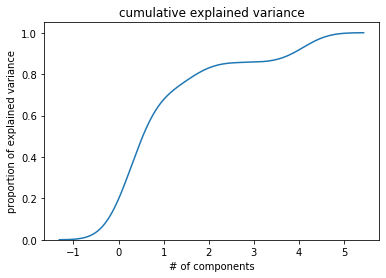

In [35]:
sns.distplot(pca.explained_variance_, hist = False,kde_kws={"cumulative":True})
plt.xlabel("# of components")
plt.ylabel("proportion of explained variance")
plt.title("cumulative explained variance")
plt.show()
#4 components

### 30) [P] Transform the z_score transformed data using your PCA model (i.e. using the transform function of the pca object.)
(NOTE: I often just store the transformed data temporarily as some arbitrary variable, X, to make it easier to
manipulate the data for plotting.)

In [39]:
x = pd.DataFrame(pca.transform(df_car_crashes_zscore),columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7"])

### 31) [P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label each point, and label your axes as component 1 and component 2, respectively.

In [49]:
pcPlot = sns.scatterplot(x.PC1,x.PC2)
for line in range(len(df_car_crashes_zscore.index)):
    pcPlot.text(x.PC1+.2,x.PC2,df_car_crashes_zscore.index[line])
plt.title("Plotting the first two principal components against eachother")
plt.show()

TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

### 32) [M] Compare the states you reported as potential outliers above to those that appear to be outliers from your plot. Do the same results seem to hold?

### 33) [P] Read how to generate a 3D scatterplot in seaborn or plotly, and use it to generate a scatterplot of the first 3 components.

### 34) [M] Do the same outliers still stand out?